# Barycenters between Gaussian mixture models (GMM) with Optimal transport

This notebook illustrates the use of the distance $GW_2$ for computing barycenters between Gaussian mixture models, as described in

[Delon, Desolneux, *A Wasserstein-type distance in the space of Gaussian Mixture Models*, 2019.](https://hal.archives-ouvertes.fr/hal-02178204)

In [1]:
# Author: Julie Delon <julie.delon 'at' parisdescartes.fr>

# import libraries
import numpy as np
import scipy.linalg as spl
import scipy.stats as sps
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import linprog
import ot                 # Optimal Transport library https://github.com/rflamary/POT

import sklearn.mixture    # for EM

from gmmot import *

## Barycenter between several multivariate Gaussian models

For $J$ probability distributions $\mu_0,\mu_1\dots,\mu_{J-1}$ on $\mathbb{R}^d$, we say that $\nu^*$ is the barycenter of the $\mu_j$ with weights $\lambda_j$ for the distance $W_2$ if $\nu^*$ is solution of 
 
 $$   \inf_{\nu \in \mathcal{P}_2(\mathbb{R}^d)} \sum_{j=0}^{J-1} \lambda_j W_2^2(\mu_j,\nu).$$
 
We write $MW_2(\mu_0,\dots,\mu_{J-1})$ the corresponding infimum.
 
If the $\mu_j$ are Gaussian distributions, we know how to compute a barycenter $\nu$ for the $\mu_j$.  To this aim, we can use the iterative algorithm described in this paper

[**A fixed-point approach to barycenters in Wasserstein space**, Pedro C. Alvarez-Esteban, E. del Barrio, J.A. Cuesta-Albertos and C. Matran](https://arxiv.org/abs/1511.05355)

If the $J$ Gaussian have covariance matrices $\Sigma_j$, at step $n$ of the algorithm the covariance matrix of the barycenter is updated as: 
$$S_{n+1} =\left(\sum_{j=1}^J \lambda_j (S_n^{1/2}\Sigma_j S_n^{1/2})^{1/2}\right),$$ 
and the mean is just the average of the means $\mu_j$ weighted by the $\lambda_j$.

The function `GaussianBarycenterW2` of gmmot.py computes this Gaussian barycenter. 

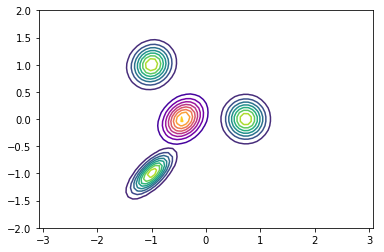

In [2]:
# exemple 

# we define three Gaussians
alpha = np.array([1/3,1/3,1/3])
m     = np.array([[-1,-1],[-1,1],[np.sqrt(3)-1,0]])
S = 0.05*np.array([[[1, 0.7],[0.7,  1]],[[1, 0.1],[0.1,  1]],[[1, 0],[0,  1]]])


# we compute their barycenter
mun,Sigman,cost = GaussianBarycenterW2(m,S,alpha,10)

# display
display_gmm([1,np.array([1]),m[0].reshape(1,2),S[0].reshape(1,2,2)],n=50,ax=-2,bx=2,ay=-2,by=2)
display_gmm([1,np.array([1]),m[1].reshape(1,2),S[1].reshape(1,2,2)],n=50,ax=-2,bx=2,ay=-2,by=2)
display_gmm([1,np.array([1]),m[2].reshape(1,2),S[2].reshape(1,2,2)],n=50,ax=-2,bx=2,ay=-2,by=2)
display_gmm([1,np.array([1]),mun,Sigman.reshape(1,2,2)],n=50,ax=-2,bx=2,ay=-2,by=2,cmap='plasma') # barycenter

## Barycenter between Gaussian mixture models

### Barycenter for $GW_2$. 

We can now focus on barycenters between GMM for the distance $GW_2$.  For $J$  Gaussian mixture models $\mu_0,\mu_1\dots,\mu_{J-1}$ on $\mathbb{R}^d$, $\nu$ is said to be a $GW_2$-barycenter of the $\mu_j$ for the weights $\lambda_j$ if $\nu$ is solution of 
$$\boxed{\inf_{\nu \in GMM_d(\infty)} \sum_{j=0}^{J-1} \lambda_j GW_2^2(\mu_j,\nu)}.$$ 

### Multi-marginal. 

Now, it can be shown that this barycenter problem has a solution given by $\boxed{\nu^* = B\# \gamma^*}$, where $B:(\mathbb{R^d})^J \mapsto \mathbb{R^d}$ sends $(x_1,\dots x_J)$ to $\sum \lambda_J x_j$ and where $\gamma^*$ is an optimal plan for the multi-marginal problem
$$
 \boxed{MGW_2(\mu_0,\dots,\mu_{J-1}):=\hspace{-0.2em}\inf_{\gamma \in \Pi(\mu_0,\dots,\mu_{J-1})\cap GMM_{Jd}(\infty)} \int_{\mathbb{R}^{dJ}}c(x_0,\dots,x_{J-1})d\gamma(x_0,\dots,x_{J-1})}$$
with 
$$c(x_0,\dots,x_{J-1}) = \sum_{i=0}^{J-1} \lambda_i\|x_i - B(x)\|^2 = \frac{1}{2} \sum_{i,j=0}^{J-1} \lambda_i\lambda_j\|x_i - x_j\|^2
$$
and where $\Pi(\mu_0,\mu_1,\dots,\mu_{J-1})$ is the set of probability
measures on $(\mathbb{R}^d)^{J}$ having $\mu_0,\mu_1,\dots,\mu_{J-1}$ as
marginals. 

### Discrete multi-marginal.

Writing for every $j$, $\mu_{j} = \sum_{k=1}^{K_j} \pi_j^k\mu_j^k$, we can show that the  solution $\gamma^*$ of the previous multimarginal problem can be written
$$\boxed{\gamma^* = \sum_{\substack{1\leq k_0 \leq K_0\\ \dots \\1\leq k_{J-1}
    \leq K_{J-1}}} w^*_{k_0 k_1\dots
  k_{J-1}}\gamma^*_{k_0 k_1\dots k_{J-1}}},$$
where $\gamma^*_{k_0 k_1\dots k_{J-1}}$ is the optimal multi-marginal plan between the
Gaussian measures $\mu_0^{k_0},\dots,\mu_{J-1}^{k_{J-1}}$
and where $w^*$ is solution of the discrete problem 
$$ \boxed{\min_{w \in \Pi(\pi_0,\dots,\pi_{J-1})} \sum_{k_0,\dots,k_{J-1}}^{K_0,\dots,K_{J-1}}w_{k_0\dots k_{J-1}}MW_2^2(\mu_0^{k_0},\dots,\mu_{J-1}^{k_{J-1}})},$$
where $\Pi(\pi_0,\pi_1,\dots,\pi_{J-1})$ is the subset of tensors $w$ in $\mathcal{M}_{K_0,K_1,\dots,K_{J-1}}(\mathbb{R}^+)$ having
$\pi_0,\pi_1,\dots,\pi_{J-1}$ as discrete marginals.


### Algorithm.

In practice we 
   - compute all the values $MW_2^2(\mu_0^{k_0},\dots,\mu_{J-1}^{k_{J-1}})$ and the Gaussians plans $\gamma^*_{k_0 k_1\dots k_{J-1}}$ between components of the GMM
   - find $w^*$ thanks to a linear programming solver (we will use `linprog` from `scipy` for solving these multi-marge problems)
   - compute  $\nu^*$ from $w^*$



In order to solve the discrete multi-marginal problem, we will use `linprog` from `scipy`. 

The function ` create_cost_matrix_from_gmm` takes as input a list containing all the parameters of the GMM, a vector of weights and an integer $N$ corresponding to the number of iterations in the function `GaussianBarycenterW2`, and gives as output the cost matrix $C$ and the list of all Gaussian barycenters between the Gaussian components of the gmm.     

The function ` solveMMOT` creates the matrices $A$ and $b$ encoding the constraints on $w$, and use `linprog` to solve 
$$\inf_{Aw=b} <C,w>.$$

## Experiments with 4 GMM in 2D

We define four GMM in 2D. 

In [3]:
# first GMM
K0 = 3
pi0 = np.array([[1/3,1/3,1/3]])
mu0 = np.array([[0.5,0.75],[0.5,0.25],[0.5,0.5]])
S0 = 0.25*np.array([[[ 0.1, 0],[0,  .005]],[[ 0.1, 0],[0, .005]],[[ .060, 0.05],[0.05,  .05]]])

# second GMM
K1 = 4
pi1 = np.array([[0.25,0.25,0.25,0.25]])
mu1 = np.array([[0.25,0.25],[0.75,0.75],[0.25,0.75],[0.75,0.25]])
S1 = np.array([[[ .01, .0],[.0,  .01]],[[ .01, 0.0],[0.0, .01]],[[ .01, 0.0],[0.0, .01]],[[ .01, 0.0],[0.0, .01]]])

# third GMM
K3 = 3
pi3 = np.array([[1/3,1/3,1/3]])
mu3 = np.array([[0.8,0.7],[0.2,0.7],[0.5,0.3]])
S3 = np.array([[[ .02, 0.01],[0.01,  .01]],[[ .02, -0.01],[-0.01,  .01]],[[ 0.06, 0],[0,  0.01]]])

# fourth GMM
K2 = 4
pi2 = np.array([[0.25,0.25,0.25,0.25]])
mu2 = np.array([[0.5,0.75],[0.5,0.25],[0.25,0.5],[0.75,0.5]])
S2 = 0.25*np.array([[[ 0.1, 0],[0,  .005]],[[ 0.1, 0],[0, .005]],[[ 0.005, 0],[0,  .1]],[[ 0.005, 0],[0,  .1]]])

We display these four GMM.

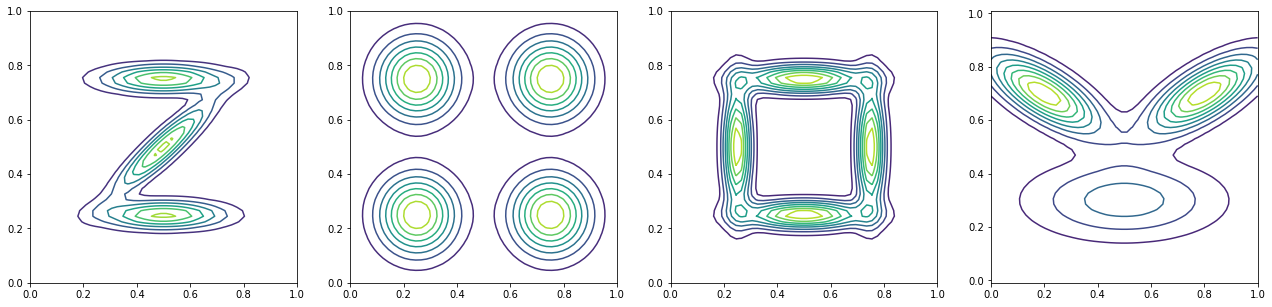

In [4]:
gmm = [[K0,pi0,mu0,S0],[K1,pi1,mu1,S1],[K2,pi2,mu2,S2],[K3,pi3,mu3,S3]]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 5))
display_gmm(gmm[0],axis=axes[0])
display_gmm(gmm[1],axis=axes[1])
display_gmm(gmm[2],axis=axes[2])
display_gmm(gmm[3],axis=axes[3])

Now we use our functions to compute the parameters and the solution of the multimarginal problem.

In [5]:
# compute and display barycenters
# gmm is a list of lists, the length of gmm is the number of models, and each model is described by a list [K,pi,mu,Sigma] 
gmm = [[K0,pi0,mu0,S0],[K1,pi1,mu1,S1],[K2,pi2,mu2,S2],[K3,pi3,mu3,S3]]
pi   = [pi0,pi1,pi2,pi3]
d = mu0.shape[1]

nb_images = 7
# four corners that will be interpolated by bilinear interpolation
v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

# result
gmminterp = []
Kn        = K0*K1*K2*K3

for i in range(nb_images):
    for j in range(nb_images):
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        if i == 0 and j == 0:
            gmminterp.append([K0,pi0,mu0,S0])
 
        elif i == 0 and j == nb_images - 1:
            gmminterp.append([K2,pi2,mu2,S2])
          
        elif i == nb_images - 1 and j == 0:
            gmminterp.append([K1,pi1,mu1,S1])
           
        elif i == nb_images - 1 and j == (nb_images - 1):
            gmminterp.append([K3,pi3,mu3,S3])
            
        else:            
            C,mun,Sn   = create_cost_matrix_from_gmm(gmm,weights)
            pin        = solveMMOT(pi, C, epsilon = 1e-10).reshape(1,Kn)
            mun,Sn     = mun.reshape(Kn,d),Sn.reshape(Kn,d,d)
            gmminterp.append([Kn,pin,mun,Sn])

/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_util.py:704: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)


We display the interpolation result.

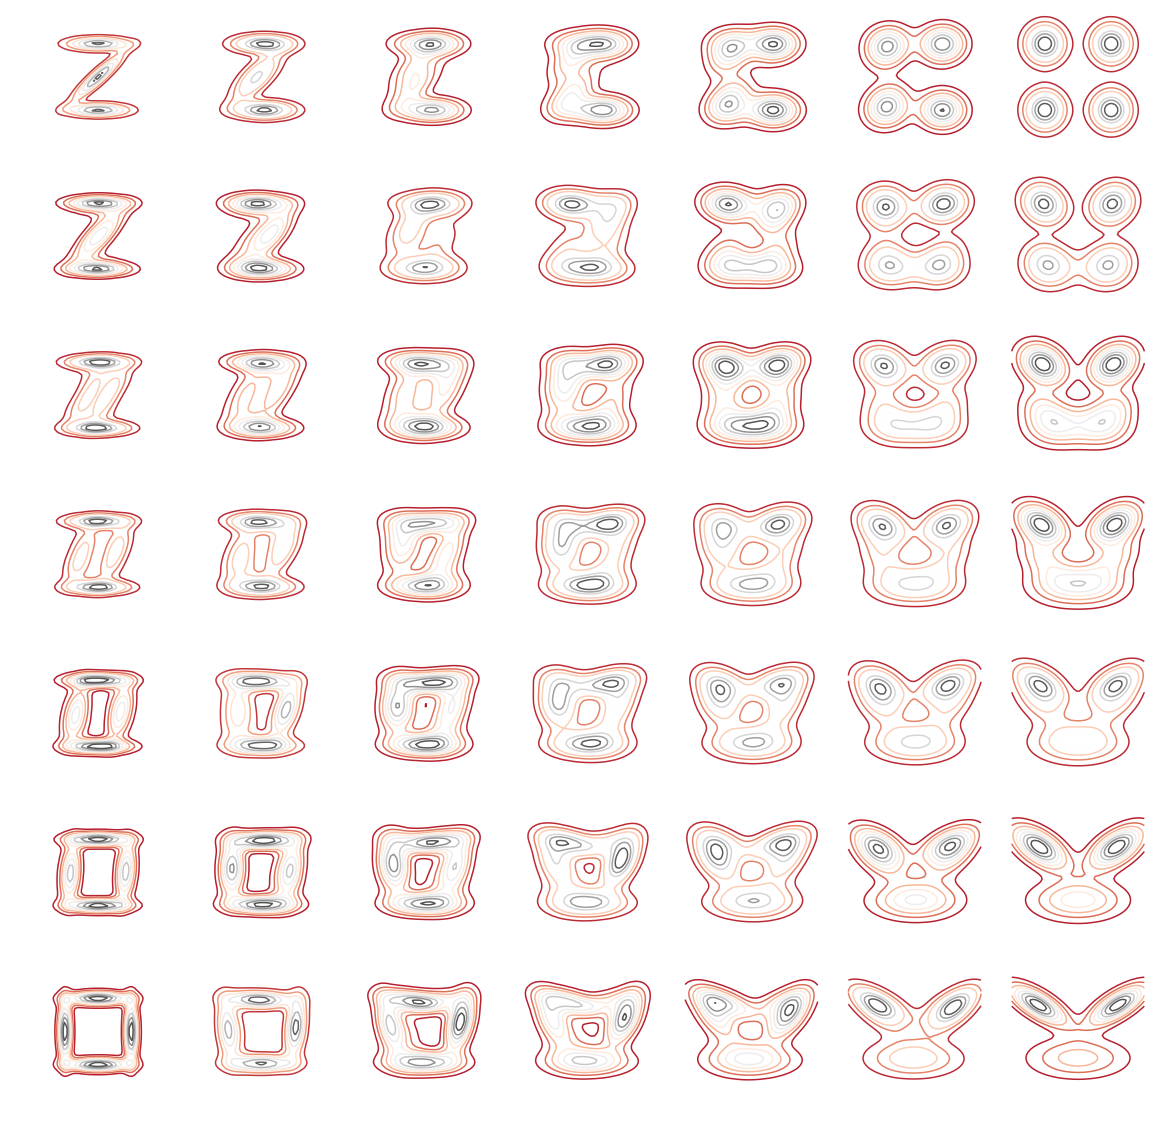

In [6]:
plt.figure(figsize=(20, 20))

for i in range(nb_images):
    for j in range(nb_images):
        axes = plt.subplot(nb_images, nb_images, i * nb_images + j + 1)
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2
        
        display_gmm(gmminterp[i+nb_images*j],cmap='RdGy')
        plt.axis('off')

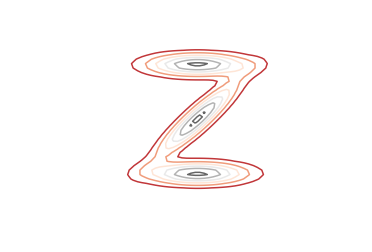

In [89]:
# create a movie of the interpolation between the four GMM

fig, ax = plt.subplots(1)

def animate(frame):
    """
    Animation function. 
    """
    if frame < nb_images-1:
        i = 0
        j = frame
    if nb_images-1 <= frame < 2*nb_images-2:
        i = frame-nb_images+1
        j = nb_images-1
    if 2*nb_images-2 <= frame < 3*nb_images-3:
        i = nb_images-1
        j = 3*nb_images - frame - 3
    if 3*nb_images-3 <= frame < 4*nb_images-4:
        i = 4*nb_images-frame-4
        j = 0    
    plt.clf()
    plt.axis('off')
    im = display_gmm(gmminterp[i+nb_images*j],cmap='RdGy')   
    return (im)

animation = FuncAnimation(fig,animate,np.arange((nb_images-1)*4))
animation.save("interpolationGW2.mp4")

## Barycenters between GMM estimated from images

We now apply the same approach to GMM appriximating binary images.

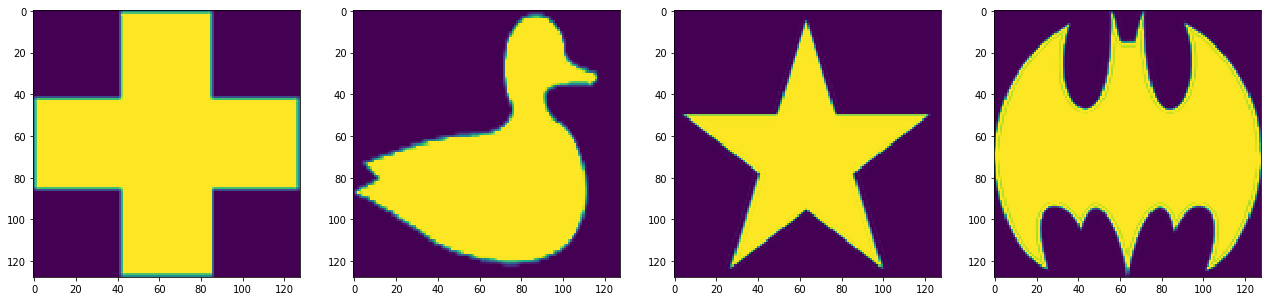

In [7]:
u1 = 1 - plt.imread('./im/redcross.png')[:, :, 2]
u2 = 1 - plt.imread('./im/duck.png')[:, :, 2]
u3 = 1 - plt.imread('./im/star.png')[:, :, 2]
u4 = 1 - plt.imread('./im/batman.png')[:, :, 2]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 5))
axes[0].imshow(u1)
axes[1].imshow(u2)
axes[2].imshow(u3)
axes[3].imshow(u4)

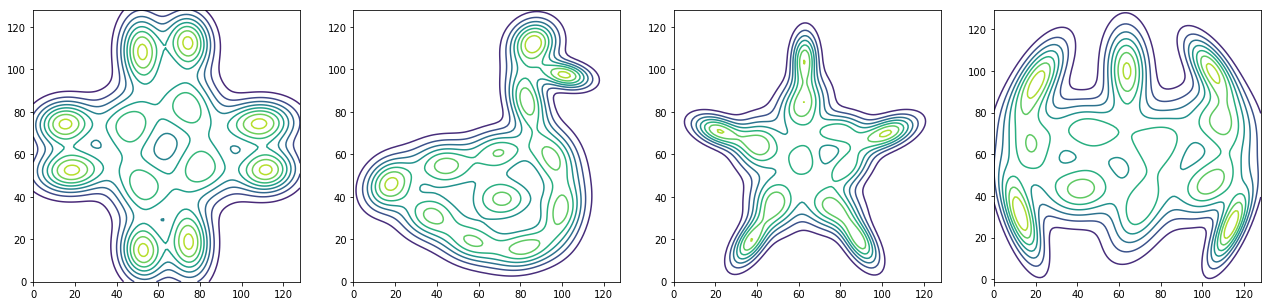

In [11]:
# transform binary images into cloud of points and approximate these clouds by gmm
k = 12 # number of classes 
i=0
gmm = []

# EM 
for u in [u1,u2,u3,u4]:
    ind = np.nonzero(u[::-1,:])
    L = ind[0].shape[0]
    X = np.zeros((L,2))
    X[:,0] = ind[1]  
    X[:,1] = ind[0]
    gmm0 = sklearn.mixture.GaussianMixture(n_components=k,covariance_type='full').fit(X)
    gmm.append([k,gmm0.weights_, gmm0.means_, gmm0.covariances_]) 
    i+=1

# display
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 5))
display_gmm(gmm[0],n=128,ax = 0,bx= 128,ay=0,by=128,axis=axes[0])
display_gmm(gmm[1],n=128,ax = 0,bx= 128,ay=0,by=128,axis=axes[1])
display_gmm(gmm[2],n=128,ax = 0,bx= 128,ay=0,by=128,axis=axes[2])
display_gmm(gmm[3],n=128,ax = 0,bx= 128,ay=0,by=128,axis=axes[3])

In [12]:
# compute and display barycenters
# gmm is a list of lists, the length of gmm is the number of models, and each model is described by a list [K,pi,mu,Sigma] 
pi   = [gmm[0][1],gmm[1][1],gmm[2][1],gmm[3][1]]
d = mu0.shape[1]

nb_images = 7
# four corners that will be interpolated by bilinear interpolation
v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

# result
gmminterp = []
Kn        = k**4

for i in range(nb_images):
    for j in range(nb_images):
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        if i == 0 and j == 0:
            gmminterp.append(gmm[0])
 
        elif i == 0 and j == nb_images - 1:
            gmminterp.append(gmm[2])
          
        elif i == nb_images - 1 and j == 0:
            gmminterp.append(gmm[1])
           
        elif i == nb_images - 1 and j == (nb_images - 1):
            gmminterp.append(gmm[3])
            
        else:            
            C,mun,Sn   = create_cost_matrix_from_gmm(gmm,weights)
            pin        = solveMMOT(pi, C, epsilon = 1e-10).reshape(1,Kn)
            mun,Sn     = mun.reshape(Kn,d),Sn.reshape(Kn,d,d)
            gmminterp.append([Kn,pin,mun,Sn])

/anaconda3/lib/python3.7/site-packages/scipy/optimize/_linprog_util.py:704: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)


We display the interpolation result.

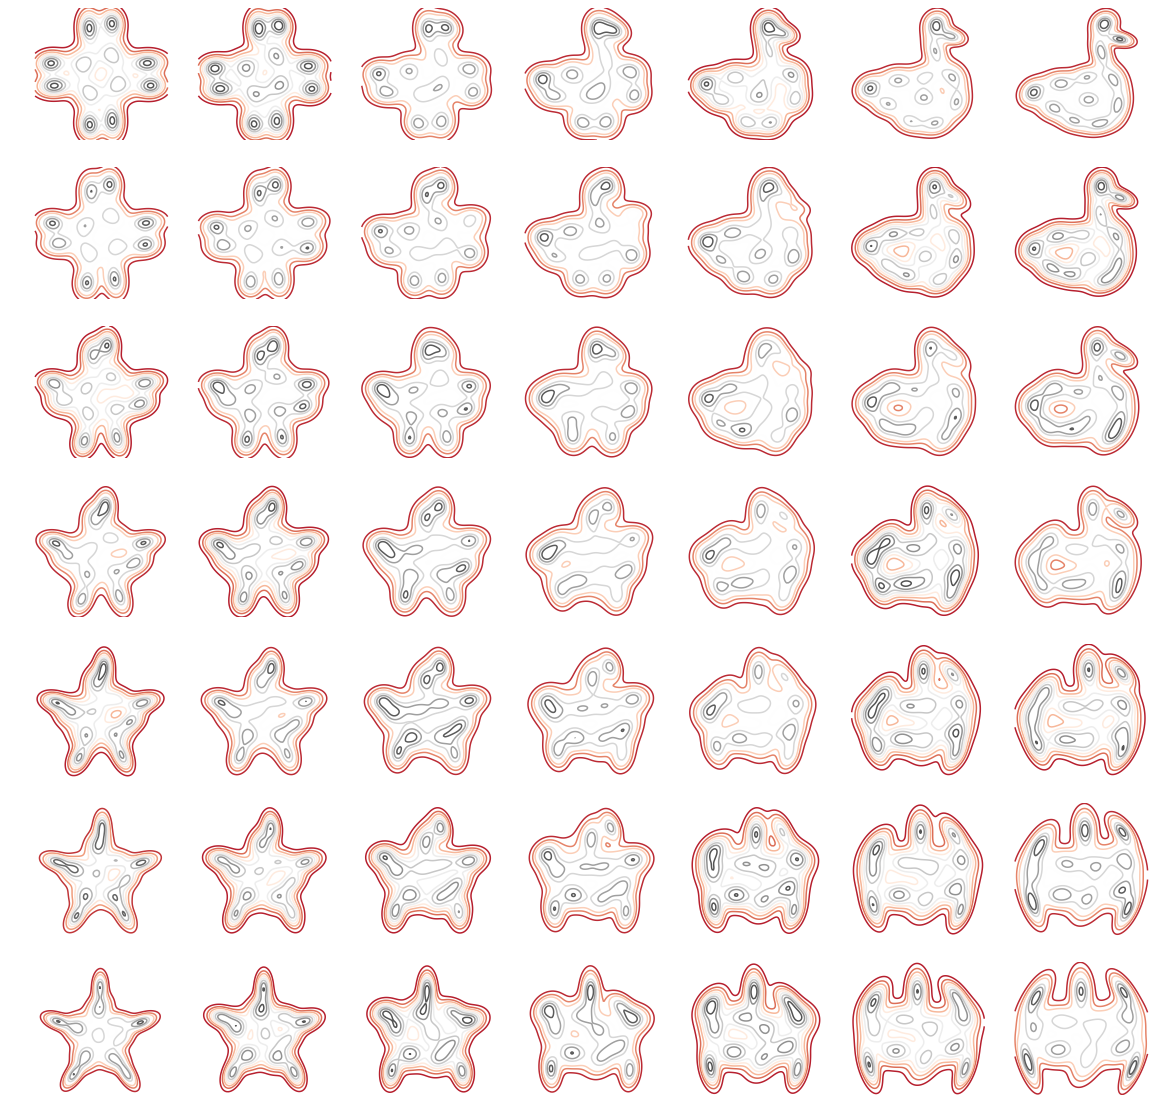

In [13]:
plt.figure(figsize=(20, 20))

for i in range(nb_images):
    for j in range(nb_images):
        axes = plt.subplot(nb_images, nb_images, i * nb_images + j + 1)
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2
        
        display_gmm(gmminterp[i+nb_images*j],n=128,ax = 0,bx= 128,ay=0,by=128,cmap='RdGy')
        plt.axis('off')

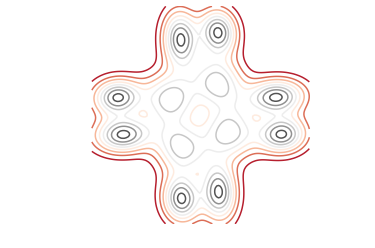

In [14]:
# create a movie of the interpolation between the four GMM

fig, ax = plt.subplots(1)

def animate(frame):
    """
    Animation function. 
    """
    if frame < nb_images-1:
        i = 0
        j = frame
    if nb_images-1 <= frame < 2*nb_images-2:
        i = frame-nb_images+1
        j = nb_images-1
    if 2*nb_images-2 <= frame < 3*nb_images-3:
        i = nb_images-1
        j = 3*nb_images - frame - 3
    if 3*nb_images-3 <= frame < 4*nb_images-4:
        i = 4*nb_images-frame-4
        j = 0    
    plt.clf()
    plt.axis('off')
    im = display_gmm(gmminterp[i+nb_images*j],n=128,ax = 0,bx= 128,ay=0,by=128,cmap='RdGy')   
    return (im)

animation = FuncAnimation(fig,animate,np.arange((nb_images-1)*4))
animation.save("interpolationGW2_images.mp4")